In [2]:
try:
    import pennylane as qml
    from pennylane import numpy as np
except ImportError:
    %pip install pennylane
    import pennylane as qml
    from pennylane import numpy as np

import matplotlib.pyplot as plt

from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error 
from qiskit_aer import AerSimulator
import qiskit

from qiskit.circuit.quantumcircuit import _compare_parameters as cp

from scipy.optimize import minimize

f = open("C:\\Users\\fouad\\Documents\\tokens.txt", "r")
next = f.readline()
TOKEN = next[:len(next)-1]
next = f.readline()
print(qml.default_config)
f.close()


In [3]:
# Setting hyper-parameters of the model: high-level parameters that determine the system we are solving

n_qubits = 3 
n_shots = 10 ** 6
tot_qubits = n_qubits + 1
ancilla_indx = n_qubits # We are using the last qubit to be the ancilla here
steps = 50 # Number of optimization steps
eta = 0.8 # "Learning rate" which is a hyperparameter that is essentially a coefficient attached to the cost 
                # sort of determines what percentage of the optimization of parameters make an effect
q_delta = 0.001 # Initial spread of random quantum weights 
rng_seed = 0 # Seed for random number generator


In [4]:
# Creating the backend and noisemodels 

# Define the basic gate set (1- and 2-qubit gates)
one_qubit_gates = ["x", "h", "s", "sdg", "ry", "rz"]
two_qubit_gates = ["cx"]
basis_gates = one_qubit_gates + two_qubit_gates 
 
## IonQ Aria (25 qubits) fidelity: 
##    1-qubit gates 99.95%, 2-qubit gate 98.95%, SPAM 99.43%
depolar_error_1q_aria = 1.0-0.9995
depolar_error_2q_aria = 1.0-0.9895
spam_error_aria = 1.0-0.9943

## IonQ Harmony (11 qubits) fidelity: 
##    1-qubit gates 99.5%, 2-qubit gate 97.5%, SPAM 99.75%
depolar_error_1q_harmony = 1.0-0.995
depolar_error_2q_harmony = 1.0-0.975
spam_error_harmony = 1.0-0.9975

noise_model_aria = NoiseModel()
noise_model_aria.add_all_qubit_quantum_error(
    depolarizing_error(depolar_error_1q_aria, 1), one_qubit_gates)
noise_model_aria.add_all_qubit_quantum_error(
    depolarizing_error(depolar_error_2q_aria, 2), two_qubit_gates)
noise_model_aria.add_all_qubit_quantum_error(
    pauli_error([('Z',spam_error_aria), ('I', 1.0-spam_error_aria)] ), "measure")

noise_model_harmony = NoiseModel()
noise_model_harmony.add_all_qubit_quantum_error(
    depolarizing_error(depolar_error_1q_harmony, 1), one_qubit_gates)
noise_model_harmony.add_all_qubit_quantum_error(
    depolarizing_error(depolar_error_2q_harmony, 2), two_qubit_gates)
noise_model_harmony.add_all_qubit_quantum_error(
    pauli_error([('Z',spam_error_harmony), ('I', 1.0-spam_error_harmony)] ), "measure")

q_device = []
q_device += ['lightning.qubit'] # Noiseless simulator
q_device += ['qiskit.aer'] # Aer without noise
q_device += ['qiskit.aer'] # Aer with noise
q_device += ['ionq.simulator']

dev_num = 0
noise_model = noise_model_aria

if dev_num == 2: 
    dev_mu = qml.device(q_device[dev_num], wires=tot_qubits, noise_model=noise_model) 
    dev_x = qml.device(q_device[dev_num], wires=n_qubits, shots=n_shots, noise_model=noise_model) 
elif dev_num == 1:
    dev_mu = qml.device(q_device[dev_num], wires=tot_qubits, backend='aer_simulator_statevector') 
    dev_x = qml.device(q_device[dev_num], wires=n_qubits, shots=n_shots, backend='aer_simulator_statevector') 
elif dev_num == 3:
    dev_mu = qml.device(q_device[dev_num], wires=tot_qubits)
    dev_x = qml.device(q_device[dev_num], wires=n_qubits, shots=n_shots) 
else:
    dev_mu = qml.device(q_device[dev_num], wires=tot_qubits)
    dev_x = qml.device(q_device[dev_num], wires=n_qubits, shots=n_shots)


In [5]:
X_0_Z_1 = [2, 1, 0]

Z_0_Z_1 = [1, 1, 0]
Z_1_Z_2 = [0, 1, 1]

X_0 = [2, 0, 0]
X_1 = [0, 2, 0]
X_2 = [0, 0, 2]

Z_0 = [1, 0, 0]
Z_1 = [0, 1, 0]
Z_2 = [0, 0, 1]

I = [0, 0, 0]

# All matrix problems
matrix = [[I, X_0_Z_1, X_0],
                [I, Z_2, Z_1],
                [I, Z_2],
                [X_0, X_1, X_2, Z_0_Z_1, Z_1_Z_2, I]]

 # Desired condition number
cond = 10
alpha = 0.5 * (1 + (1/cond))
beta = 0.5 * (1 - (1/cond))

# Using these paramters for matrix 3
zeta_c = 0.1
eta_c = 0.96034655

# All coefficient sets
c_all= [[1.0, 0.2, 0.2],
        [1.0, 0.7512195, 0.2],
        [1.0, 0.785, 0.2],
        [0.55, 0.225, 0.225],
        [alpha, beta],
        [(1/zeta_c), (1/zeta_c), (1/zeta_c), (0.1/zeta_c), (0.1/zeta_c), (eta_c/zeta_c)]]

# Current matrix 
m_num = 0

# Current coefficient set of the linear combination A = c_0 A_0 + c_1 A_1 ...
c = c_all[m_num]

In [6]:
# Defining the unitary operations associated to an example A matrix

# The unitary matrix that prepares a |b> state; |b> = U|0>
# We don't need to find the transpose of this matrix, or even make it 
# a controlled operation since it will be part of the initial state preparation 
# for calculating the expectation value
def U_b():
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx) # A hadamard from q_0 to q_{n_qubits-1}, where the final qubit is the control

# This function defines a controlled decomposition of the A matrix into
# corresponding controlled gate sequences. The gate_type parameter takes
# in an array of up to n_qubits elements, where the nth element of the array
# defines the controlled operation on the nth qubit. The exact descriptors are
# shown below:
# 
# 0: Identity gate, no action.
# 1: controlled-Z gate
# 2: controlled-X (CNOT ) gate
def CA_exp(gate_type):
    for i in range(len(gate_type)):
        if gate_type[i] == 1:
            qml.CZ(wires=[ancilla_indx, i])
        elif gate_type[i] == 2:
            qml.CNOT(wires=[ancilla_indx, i])

# A wrapper function for CA_exp that deals with multiple matrix 
# problems 
def CA(idx):
    CA_exp(matrix[m_num][idx])



In [7]:
# Variational quantum circuit that prepares a solutions state |x> = V(k)|0>
def variational_block(weights):

    # We first put the qubits in a superposition using Had gates
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

    # First layer of rotation gates
    for idx, element in enumerate(weights[0:3]):
        qml.RY(element, wires=idx)
    
    # Using CZ gates to entangle wires
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])

    # Second layer of rotation gates
    for idx, element in enumerate(weights[3:6]):
        qml.RY(element, wires=idx)

    # Using CZ gates to entangle wires
    qml.CNOT(wires=[1, 0])
    qml.CNOT(wires=[1, 2]) 

    # Third layer of rotation gates
    for idx, element in enumerate(weights[6:9]):
        qml.RY(element, wires=idx)


In [8]:
# Hadamard Test

@qml.qnode(dev_mu, interface="autograd")
def local_hadamard_test(weights, l=None, lp=None, j=None, part=None):

    # First Hadamard gate applied to the ancillary qubit
    qml.Hadamard(wires=ancilla_indx)

    #For estimating the imaginary part of the coefficient "mu", we must add an "-i"
    # phase gate
    if part.lower() == "im":
        qml.PhaseShift(-np.pi / 2, wires=ancilla_indx)

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # Controlled application of the unitary component A_l of the problem matrix A
    CA(l)

    # Adjoint of the unitary U_b associated to the problem vector |b>
    # In this example, Adj(U_b) = U_b
    U_b()

    # Controlled Z operator at position j. If j = -1, apply the identity
    if j != -1:
        qml.CZ(wires=[ancilla_indx, j])
    
    # Unitary U_b associated to the problem vector |b>
    U_b()

    # Controlled application of Adjoint(A_lp).
    # In this specific example Adjoing(A_lp) = A_lp
    CA(lp)

    # Second Hadamard gate applied to the ancillary qubit
    qml.Hadamard(wires=ancilla_indx)

    # Expectation value of Z for the ancillary qubit
    return qml.expval(qml.PauliZ(wires=ancilla_indx))

# Generates the coefficients to compute the "local" cost function C_L
def mu(weights, l=None , lp=None, j=None):
    
    mu_real = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Re") # Real part of the expectation value
    #mu_imag = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Im") # Imaginary part of the expectation value
    return mu_real #+ 1.0j * mu_imag

    

In [9]:
# Local Cost Function

# Returns the normalization constant <psi|psi>, where |psi> = A|x>
def psi_norm(weights):

    norm = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            mu_res = mu(weights, l, lp, -1)
            norm += c[l] * np.conj(c[lp]) * mu_res

    return abs(norm)

# Local version of the cost function, which tends to zero when A|x> is proportional to |b>
def cost_loc(weights):
    global cost
    
    mu_sum = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            for j in range(0, n_qubits):
                mu_res = mu(weights, l, lp, j)
                mu_sum += c[l] * np.conj(c[lp]) *mu_res
    
    mu_sum = abs(mu_sum)

    # Return the cost function C_L
    cost = 0.5 - 0.5 * mu_sum / (n_qubits * psi_norm(weights))    
    return cost


In [10]:
np.random.seed(rng_seed)
w = q_delta * np.random.randn(n_qubits*3, requires_grad=True)
w_reset = w
def log_cost(x):
    cost_history.append(cost)
    print(cost)


# out = minimize(cost_loc, x0=w, method='COBYLA', options={'maxiter':MAX_ITER}, callback=log_cost)
#w = out.x

In [59]:
MAX_ITER = 1000

opt = []
opt += [qml.GradientDescentOptimizer(eta)]
opt += [qml.QNGOptimizer(eta)]

m_num = 0
epsilon = 0.01
c_mid_all = [0.704762, 0.7354838, 0.7512195, 0.7607843, 0.7672131] # 0.2, 0.3, 0.4, 0.6, 0.7, 0.74, 0.75,  0.76,
cond = [20, 30, 40, 50, 60] #2.3333, 3, 4, 9, 19, 32.3333, 39, 49,
cost_history = [[] for x in range(len(c_mid_all))]
time_to_solution = []

for num in range(len(c_mid_all)):

    m_num = 0 #num
    c = [1, c_mid_all[num], 0.2] # c_all[num]
    w = w_reset
    gamma = (epsilon**2)/(n_qubits * (cond[num]**2))

    restarted = False
    gradient = False

    for it in range(MAX_ITER):
        w, cost = opt[1].step_and_cost(cost_loc, w)
        if gradient and not restarted and it > 0 and cost > cost_history[num][len(cost_history[num]) -1]:
            res_eps = np.sqrt(cost_history[num][len(cost_history[num]) -1] * n_qubits * (cond[num] ** 2))
            print("Forced convergence with epsilon = " + str(res_eps))
            print("Trying again, with new w...")
            w = q_delta * np.random.randn(n_qubits*3, requires_grad=True)
            restarted = True
            continue

        restarted = False

        print("Step {:3d}       Cost = {:9.7f}".format(it, cost))
        cost_history[num].append(cost)

        if cost < gamma:
            print("Converged")
            time_to_solution += [it]
            break
    


ValueError: The objective function must either be encoded as a single QNode or an ExpvalCost object for the natural gradient to be automatically computed. Otherwise, metric_tensor_fn must be explicitly provided to the optimizer.

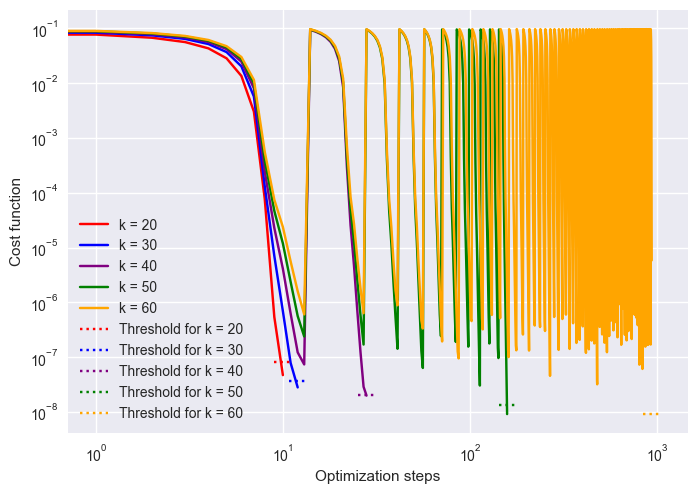

In [55]:
colors = ['red', 'blue', 'purple', 'green', 'orange', 'purple']
for k in range(0, len(c_mid_all)):
    #plt.semilogx(cost_history[k], label= "|0...0> starting state" if k ==0 else "H_n|0...0> starting state")
    plt.loglog(cost_history[k], label="k = " + str(cond[k]), color=colors[k])
for num in range(len(c_mid_all)):
    gamma = (epsilon**2)/(n_qubits * (cond[num]**2))
    bind = len(cost_history[num]) -1
    plt.hlines(gamma, 0.9*bind, 1.1*bind, label = "Threshold for k = " + str(cond[num]), color=colors[num], linestyles="dotted")
plt.legend()
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

In [ ]:
# Classically finding the solution for our system

Id = np.identity(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
m_num = 1
c = c_all[m_num]
A = np.zeros((8,8))
for r in range(len(matrix[m_num])):
    ad = []
    for f in range(len(matrix[m_num][r])):
        switch = matrix[m_num][r][f]
        if switch == 0:
            ad += [Id]
        elif switch == 1:
            ad += [Z]
        elif switch == 2:
            ad += [X]
    A = np.add(A, c[r] * np.kron(np.kron(ad[0], ad[1]), ad[2]))

b = np.ones(8) / np.sqrt(8)

print("A = " + str(A))
print("b = " + str(b))

A_inv = np.linalg.inv(A)
x = np.dot(A_inv, b)

c_probs = (x / np.linalg.norm(x)) ** 2

A = [[ 1.         0.2        0.         0.         0.7512195  0.
   0.         0.       ]
 [ 0.2        1.         0.         0.         0.         0.7512195
   0.         0.       ]
 [ 0.         0.         1.         0.2        0.         0.
  -0.7512195  0.       ]
 [ 0.         0.         0.2        1.         0.         0.
   0.        -0.7512195]
 [ 0.7512195  0.         0.         0.         1.         0.2
   0.         0.       ]
 [ 0.         0.7512195  0.         0.         0.2        1.
   0.         0.       ]
 [ 0.         0.        -0.7512195  0.         0.         0.
   1.         0.2      ]
 [ 0.         0.         0.        -0.7512195  0.         0.
   0.2        1.       ]]
b = [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]


In [ ]:
# Now we will sample the quantum circuit with our optimized parameters to find the circuit's best guess to the solution
# and compare it with the solution we can find classicaly

@qml.qnode(dev_x, interface="autograd")
def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()

raw_samples = prepare_and_sample(w)

# convert the raw samples (bit strings) into integers and count them
samples = []
for sam in raw_samples:
    samples.append(int("".join(str(bs) for bs in sam), base=2))

q_probs = np.bincount(samples) / n_shots

x_n^2 =      |<x|n>|^2 = 
0.012561          0.012341
0.012561          0.012376
0.237439          0.236977
0.237439          0.238040
0.012561          0.012605
0.012561          0.012563
0.237439          0.237810
0.237439          0.237288


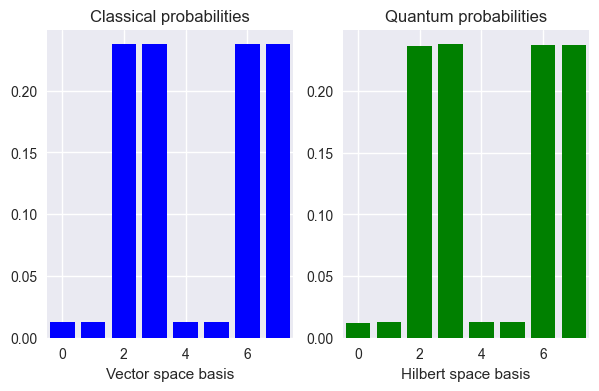

Accuracy: 0.9996414364934942


In [ ]:
print("x_n^2 =      |<x|n>|^2 = " )

for i in range(len(c_probs)):
    print("{:.6f}          {:.6f}".format(c_probs[i], q_probs[i]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()

from numpy import linalg
acc = np.dot(c_probs, q_probs) / (np.linalg.norm(q_probs) ** 2)

print("Accuracy: " + str(acc))